This notebook evaluates the correctness of AZKAG for our method based on biclique-graph-patterns and the classical method based on frequent-patterns. We report Recall, Precision and F-score using two types of synthetic examples for the negatives: from random sampling, and from our generation procedure. We also report some statitics about the resulting examples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from src import avpattern as avp
from efficient_apriori import apriori


### Load access control graph

In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


In [3]:
#Get attribute-values of users
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)
userlog_objs = ut.to_tuple_format(userlog_objs)

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

### Useful functions

In [4]:
def res_requesters_distrib(usrvidx_resvidx_tups):
    resvidxset = set()
    for tup in usrvidx_resvidx_tups:
        resvidxset.add(tup[1])
    num_requesters = []
    for resvidx in list(resvidxset):
        num_requesters.append(len(gur.neighbors(resvidx)))

    num_requesters_to_freq = dict(Counter(num_requesters))
    num_requesters_to_freq = dict(sorted(num_requesters_to_freq.items(), key=lambda item: item[1]))
    totalf = sum(num_requesters_to_freq.values())

    x = num_requesters_to_freq.keys()
    y = [f/totalf for f in num_requesters_to_freq.values()]
    plt.loglog(x, y, '.')
    plt.xlabel('num requesters')
    plt.ylabel('p')
    plt.show()

In [5]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [6]:
def next_vertex(gur, v):
    neighvidxs = gur.neighbors(v)
    i = random.randint(0,len(neighvidxs)-1)
    return gur.vs[neighvidxs[i]]
    

def get_entry_tupes(gur, max_hops, alpha, sd):
    random.seed(sd)
    usrvidx_resvidx_tups = list()
    
    for v in gur.vs:
        if v['type']: #Only resources
            neighvidxsset = set(gur.neighbors(v))
            deg = len(neighvidxsset)
            usrvidxsset = set()

            count = 0
            while len(usrvidxsset) < alpha*deg:
                v_ = v
                for i in range(max_hops):
                    v2 = next_vertex(gur, v_)
                    if i == max_hops-1 and not v2.index in neighvidxsset:
                        usrvidxsset.add(v2.index)
                    else:
                        v_ = v2
                count += 1
                
                if count > 100000:
                    break
                    
            for usrvidx in list(usrvidxsset):
                usrvidx_resvidx_tups.append((usrvidx,v.index))
        
    return usrvidx_resvidx_tups


def filter_sim(gur, usrvidx_resvidx_tups, thmin, thmax):
    usrvidx_resvidx_tups_ = []
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        cs = cosine_sim(gur, usrvidx, resvidx)
        if cs > thmin and cs <= thmax:
            usrvidx_resvidx_tups_.append(tup)
    
    return usrvidx_resvidx_tups_


def filter_atts(gur, usrvidx_resvidx_tups, minth, maxth):
    usrvidx_resvidx_tups_ = []
    
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        
        usrattvalsset = set(userlog_objs[usrvidx])
        neighattvalsset = set(resvidx_to_neighattvals[resvidx])
        
        x = len(usrattvalsset&neighattvalsset)
        if x > minth and x <= maxth:
            usrvidx_resvidx_tups_.append(tup)
            
    return usrvidx_resvidx_tups_
    

def get_non_entries(gur, numentries, sd):
    edges_tuples = []
    for e in gur.es:
        edges_tuples.append((e.source,e.target))

    usrvidxs = []
    resvidxs = []
    for v in gur.vs:
        if v['type']:
            resvidxs.append(v.index)
        else:
            usrvidxs.append(v.index)

    random.seed(sd)
    usrvidxs_random = random.choices(usrvidxs,k=10*numentries)
    resvidxs_random = random.choices(resvidxs,k=10*numentries)

    i = 0
    j = 0
    usrvidx_resvidx_tups_non = []
    while i < numentries:
        tup = (usrvidxs_random[j], resvidxs_random[j])
        if not tup in edges_tuples: 
            usrvidx_resvidx_tups_non.append(tup)
            i += 1
        j += 1
        
    return usrvidx_resvidx_tups_non


### Create synthetic examples through our method

In [7]:
#Synthetic positives (our method)
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.2, thmax=100)
usrvidx_resvidx_tups_pos = filter_atts(gur, usrvidx_resvidx_tups_, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos))

Num of pos examples: 16744


In [8]:
random.seed(13)
usrvidx_resvidx_tups_pos = random.sample(usrvidx_resvidx_tups_pos,1600) #Because AZKAG has 32K entries

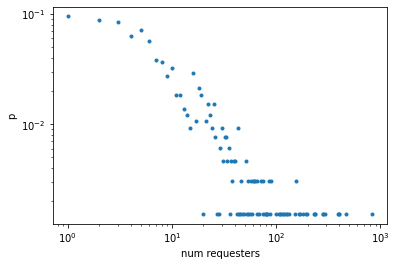

In [9]:
#Distribution of synthetic positives (our method)
res_requesters_distrib(usrvidx_resvidx_tups_pos)

In [10]:
#Synthetic negatives (our method)
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.05, thmax=0.2)
usrvidx_resvidx_tups_neg = filter_atts(gur, usrvidx_resvidx_tups_, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg))

Num of neg examples: 5106


In [11]:
random.seed(13)
usrvidx_resvidx_tups_neg = random.sample(usrvidx_resvidx_tups_neg,1600) #Because AZKAG has 32K entries

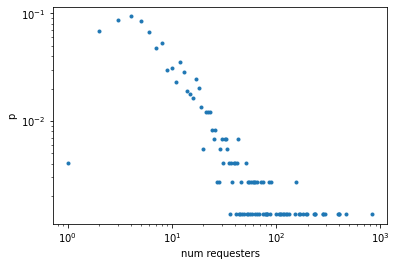

In [12]:
#Distribution of synthetic negatives (our method)
res_requesters_distrib(usrvidx_resvidx_tups_neg)

### Create synthetic negative examples through random sampling

In [13]:
usrvidx_resvidx_tups = get_non_entries(gur, numentries=20000, sd=13)
usrvidx_resvidx_tups_neg_random = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_random))

Num of neg examples: 4575


In [14]:
random.seed(13)
usrvidx_resvidx_tups_neg_random = random.sample(usrvidx_resvidx_tups_neg_random,1600)
#Because AZKAG has 32K entries

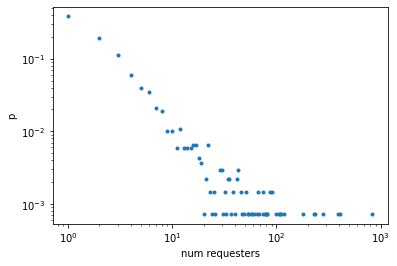

In [15]:
#Distribution of synthetic negatives (our method)
res_requesters_distrib(usrvidx_resvidx_tups_neg_random)

### Evaluate biclique graph patterns

In [16]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('Total bicliques:', len(bcs))

Total bicliques: 17563


In [17]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 1:
        nusr = len(bc.get_usrids())
        nres = len(bc.get_resids())
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 12263


In [18]:
with open('data_structures/azkag_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

In [19]:
bcid_to_bc = {bc.get_id():bc for bc in subbcs}
gps = bcg.dfs(bcgraph, bcid_to_bc, sa=1)
print('Num graph patterns:', len(gps))

Num graph patterns: 6886


In [20]:
gps_final = []
for gpidx,gp in enumerate(gps):
    if len(gp[1]) < 50:
        gps_final.append(gp)

gps_final = [gp for gp in gps_final if len(gp[0])>1]

In [21]:
len(gps_final)

6375

In [22]:
#Create mappings
rules = [gp[0] for gp in gps_final]

bcid_to_ruleidxs = dict()
for ruleidx,gp in enumerate(gps_final):
    for bcid in gp[1]:
        if not bcid in bcid_to_ruleidxs:
            bcid_to_ruleidxs[bcid] = []
        bcid_to_ruleidxs[bcid].append(ruleidx)
        
#Agregado debido que ahora cargo el grafo de respaldo
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx
    
resid_to_bcids = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    resids_ = bc.get_resids()
    for resid in resids_:
        if not resid in resid_to_bcids:
            resid_to_bcids[resid] = []
        resid_to_bcids[resid].append(bcid) 

In [23]:
def evaluate_bgp(gur, usrvidx_resvidx_tups):

    num_valid = 0
    num_trues = 0

    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if resid in resid_to_bcids:
            ruleidxs = set()
            for bcid in resid_to_bcids[resid]:
                if bcid in bcid_to_ruleidxs:
                    ruleidxs |= set(bcid_to_ruleidxs[bcid])

            ruleidxs = list(ruleidxs)

            if len(ruleidxs) > 0:
                num_valid += 1

            for ruleidx in ruleidxs:
                rule = rules[ruleidx]
                if len(set(usrattvals)&set(rule)) == len(rule):
                        num_trues += 1
                        break
                        
    return num_valid, num_trues
            
            

In [30]:
n = len(usrvidx_resvidx_tups_pos)
num_pos, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg)
print('TPR', num_truepos/n)
print('FPR', num_falsepos/n)

recall = num_truepos/n
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Precision:', precision)
print('Fscore:', fscore)

TPR 0.8675
FPR 0.216875
Precision: 0.8
Fscore: 0.8323838080959521


In [31]:
n = len(usrvidx_resvidx_tups_pos)
num_pos, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_random)
print('TPR', num_truepos/n)
print('FPR', num_falsepos/n)

recall = num_truepos/n
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Precision:', precision)
print('Fscore:', fscore)

TPR 0.8675
FPR 0.0875
Precision: 0.9083769633507853
Fscore: 0.887468030690537


### Evaluation frequent patterns

In [26]:
global_f = 5
resid_to_valsentries,resid_to_patterns=\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [27]:
def evaluate_fp(gur, usrvidx_resvidx_tups):
    num_valid = 0
    num_trues = 0
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if len(resid_to_patterns[resid]) > 0:
            num_valid += 1

        for rule in resid_to_patterns[resid]:
            if len(set(usrattvals)&set(rule)) == len(rule):
                    num_trues += 1
                    break
                    
    return num_valid, num_trues
    

In [32]:
n = len(usrvidx_resvidx_tups_pos)
num_pos, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg)
print('TPR', num_truepos/n)
print('FPR', num_falsepos/n)

recall = num_truepos/n
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Precision:', precision)
print('Fscore:', fscore)

TPR 0.585
FPR 0.095
Precision: 0.8602941176470589
Fscore: 0.6964285714285714


In [33]:
n = len(usrvidx_resvidx_tups_pos)
num_pos, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_random)
print('TPR', num_truepos/n)
print('FPR', num_falsepos/n)

recall = num_truepos/n
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Precision:', precision)
print('Fscore:', fscore)

TPR 0.585
FPR 0.0175
Precision: 0.970954356846473
Fscore: 0.7301092043681746


In [ ]:
#Fscore lower for fp
#This is because some of the example contemples resources low requested